In [95]:
import pandas as pandas
import datetime
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm 
import warnings

In [96]:
data = pd.read_excel('data skripsi.xlsx')
print(data.head())

  Kabupaten  Tahun  Produksi  Luas Panen  Curah Hujan  Kelembapan  \
0     Toili   2004   1449671      359817         2400        84.0   
1     Toili   2005   1429440      336765         2410        83.9   
2     Toili   2006   1550548      295212         2420        83.8   
3     Toili   2007   1718193      315131         2430        83.7   
4     Toili   2008   1522556      367636         2440        83.6   

   Suhu rata-rata  
0           26.40  
1           26.41  
2           26.42  
3           26.43  
4           26.44  


In [97]:
import plotly.express as px
figure = px.line(data, x="Tahun", y="Produksi", title="Hasil Prediksi Padi")
figure.show()

<Figure size 640x480 with 0 Axes>

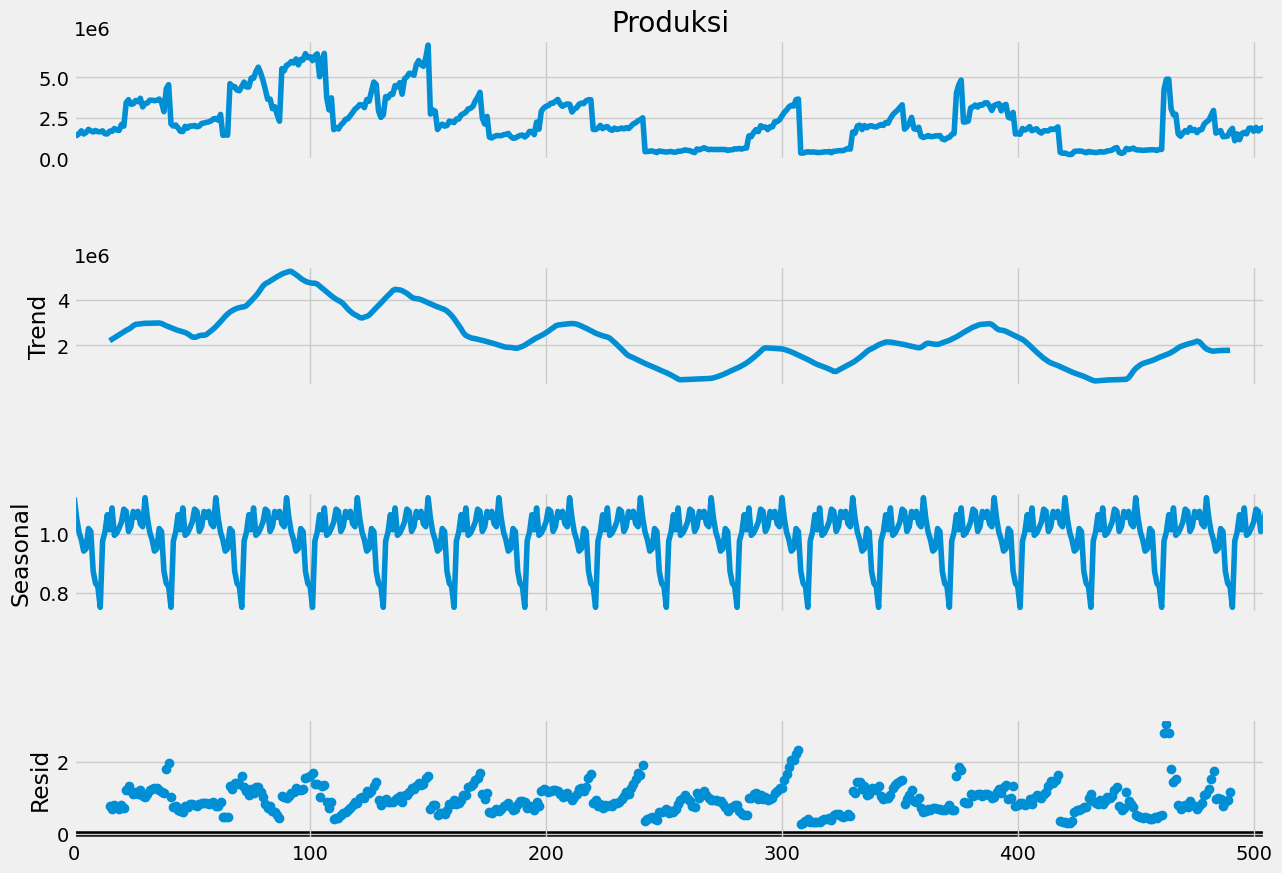

In [98]:
result = seasonal_decompose(data["Produksi"], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(15,10)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

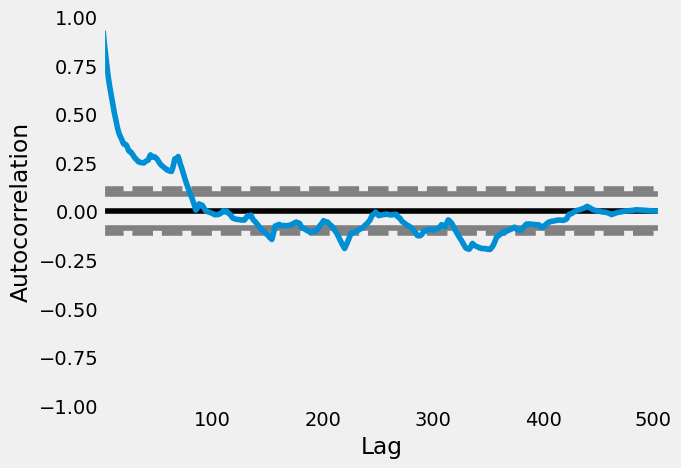

In [99]:
pd.plotting.autocorrelation_plot(data["Produksi"])

In [100]:
d = 1 
p = 3 

In [101]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data["Produksi"])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Data stasioner (tolak H0)")
else:
    print("Data tidak stasioner (gagal tolak H0)")


ADF Statistic: -4.323481255701208
p-value: 0.0004044105498573557
Data stasioner (tolak H0)


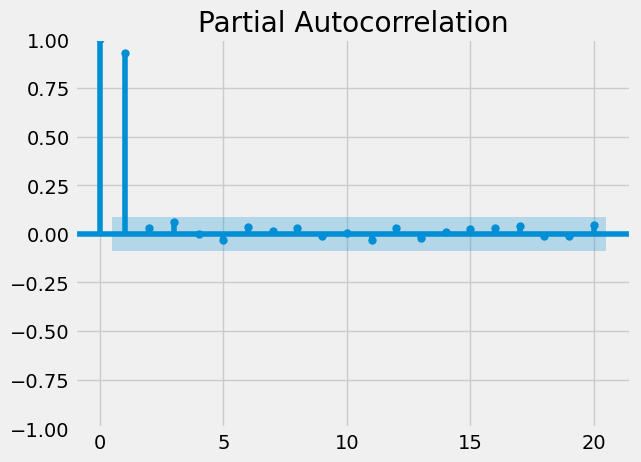

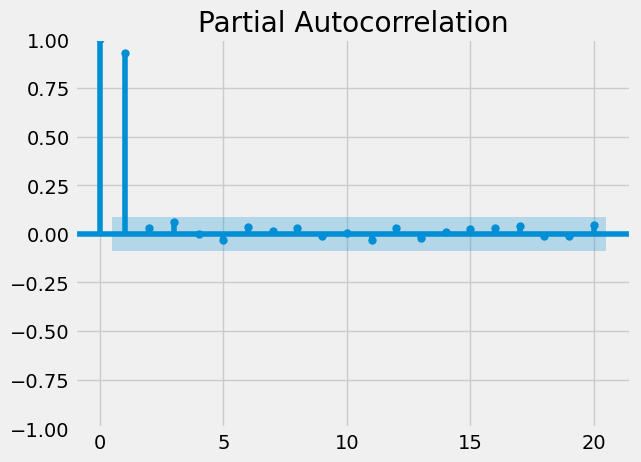

In [102]:
# mencari nilai q
plot_pacf(data["Produksi"], lags = 20)

In [103]:
q= 2

In [104]:

# Membuat model ARIMA (bukan SARIMA karena data tahunan)
model = sm.tsa.ARIMA(data["Produksi"], order=(p,d,q))
model = model.fit()

print(model.summary())

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:               Produksi   No. Observations:                  506
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -7390.044
Date:                Mon, 21 Jul 2025   AIC                          14792.087
Time:                        12:57:38   BIC                          14817.434
Sample:                             0   HQIC                         14802.029
                                - 506                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1053      0.053     -1.971      0.049      -0.210      -0.001
ar.L2          0.9034      0.026     34.119      0.000       0.852       0.955
ar.L3          0.0141      0.051      0.276      0.7

In [105]:
# membuat prediksi
predictions = model.predict(len(data), len(data)+5)
print(predictions)

506    1.931853e+06
507    1.899622e+06
508    1.886170e+06
509    1.858196e+06
510    1.848533e+06
511    1.824088e+06
Name: predicted_mean, dtype: float64


<Axes: >

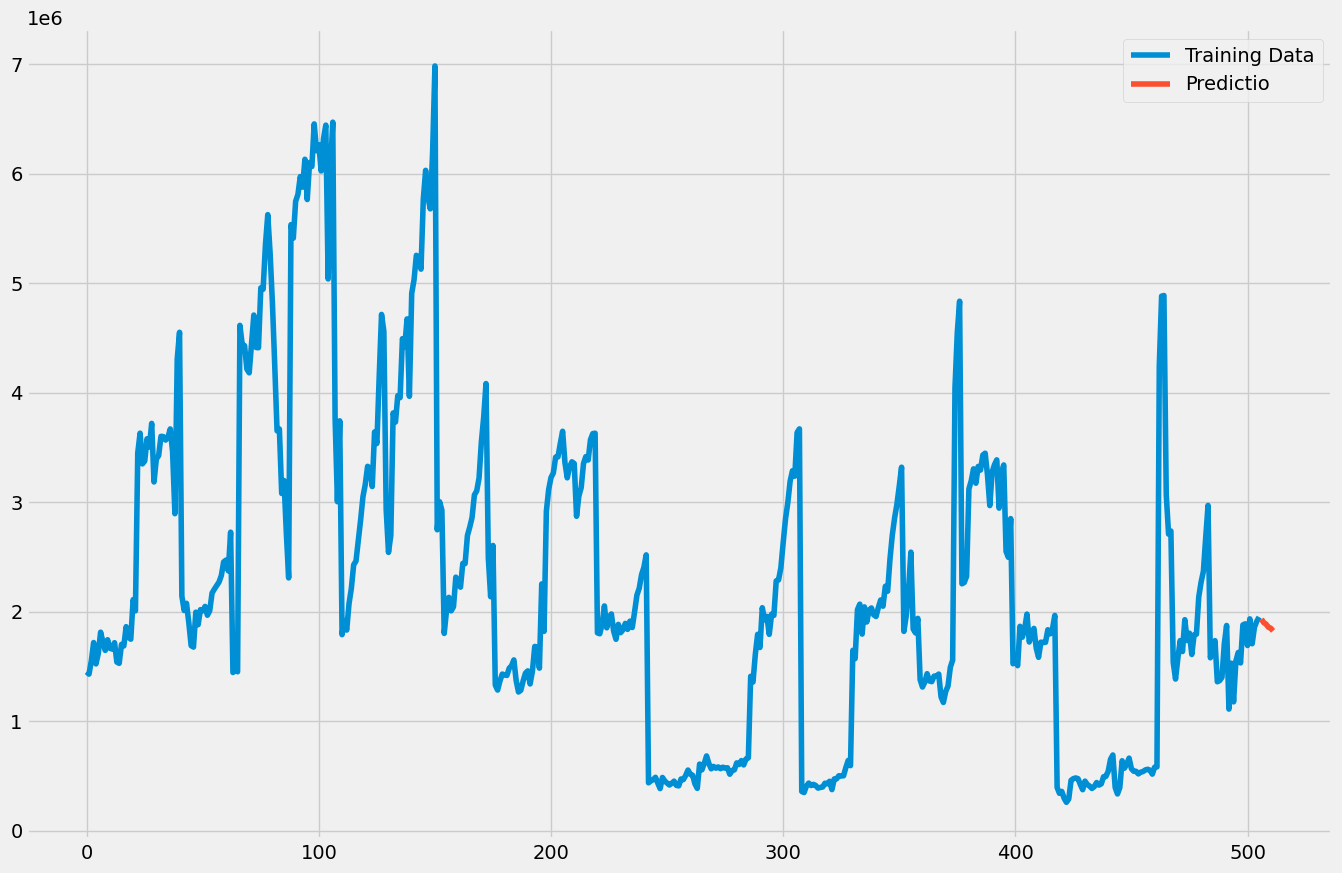

In [106]:
#buat grafik
data["Produksi"].plot(legend=True,
                      label="Training Data",
                      figsize=(15,10))
predictions.plot(legend=True,label="Predictio")

In [107]:
# Pastikan tahun dalam integer
last_year = int(data["Tahun"].iloc[-1])

# Buat 5 tahun ke depan sebagai index (akhir tahun)
future_years = pd.date_range(start=f"{last_year+1}", periods=5, freq='Y')

# Pastikan panjang prediksi cocok
predictions = predictions[:5]  # jika perlu

# Set index ke prediksi
predictions.index = future_years

C:\Users\asus\AppData\Local\Temp\ipykernel_11608\3013102231.py:5: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



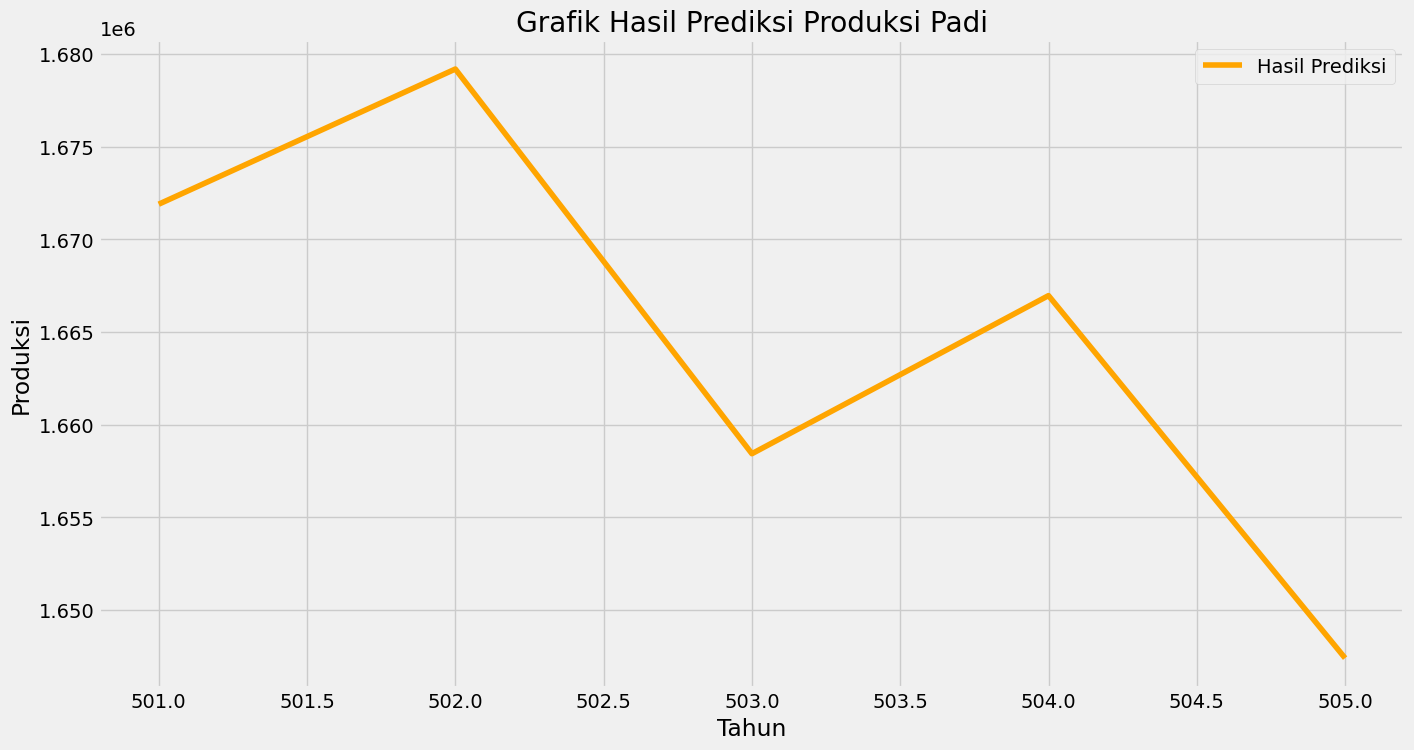

In [128]:
# Tampilkan hanya grafik hasil prediksi
plt.figure(figsize=(15, 8))
plt.plot(predictions, label="Hasil Prediksi", color='orange')
plt.title("Grafik Hasil Prediksi Produksi Padi")
plt.xlabel("Tahun")
plt.ylabel("Produksi")
plt.legend()
plt.show()


In [ ]:
# Misal kita uji 5 tahun terakhir sebagai test set (80% data untuk pelatihan dan 20% data untuk pengujian)
train = data["Produksi"][:-5]
test = data["Produksi"][-5:]

In [110]:
model = sm.tsa.ARIMA(train, order=(p, d, q))
model_fit = model.fit()

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [111]:
predictions = model_fit.forecast(steps=len(test))

In [112]:

comparison = pd.DataFrame({
    'Actual': test.values,
    'Predicted': predictions
}, index=test.index)

print(comparison)


      Actual     Predicted
501  1934428  1.671894e+06
502  1707018  1.679185e+06
503  1858374  1.658431e+06
504  1912114  1.666961e+06
505  1951109  1.647402e+06


In [113]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape:.2f}%")


MAE: 207833.81038871082
RMSE: 228916.41776335586
MAPE: 10.87%


In [114]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [115]:
# Ambil nilai produksi sebagai array
data_series = data['Produksi'].values
years = data['Tahun'].values

In [116]:
# Tentukan jumlah interval fuzzy (misal: 7)
interval_count = 7
min_val, max_val = np.min(data_series), np.max(data_series)
interval_length = (max_val - min_val) / interval_count

In [117]:
# Buat interval fuzzy
intervals = [(min_val + i * interval_length, min_val + (i + 1) * interval_length) for i in range(interval_count)]

In [118]:
# Fungsi fuzzifikasi (tentukan index interval untuk setiap nilai)
def fuzzify(value):
    for i, (low, high) in enumerate(intervals):
        if low <= value <= high:
            return i
    return -1

In [119]:
# Lakukan fuzzifikasi untuk semua data
fuzzy_data = [fuzzify(val) for val in data_series]

In [120]:
# Prediksi 1 langkah ke depan: jika nilai sebelumnya di interval i, maka nilai prediksi adalah rata-rata dari semua nilai setelahnya yang juga dari i
transition_dict = {}
for i in range(len(fuzzy_data) - 1):
    key = fuzzy_data[i]
    if key not in transition_dict:
        transition_dict[key] = []
    transition_dict[key].append(data_series[i+1])

In [121]:
# Buat prediksi berdasarkan rata-rata transisi
predicted = []
for i in range(len(fuzzy_data) - 1):
    key = fuzzy_data[i]
    if key in transition_dict and len(transition_dict[key]) > 0:
        pred = np.mean(transition_dict[key])
    else:
        pred = np.nan
    predicted.append(pred)

In [122]:
# Sisipkan nan di awal agar sejajar
predicted.insert(0, np.nan)

# Evaluasi prediksi (hilangkan nan)
actual = data_series[1:]
predicted_values = np.array(predicted[1:])

In [123]:
# Evaluasi metrik
mae_fts = mean_absolute_error(actual, predicted_values)
rmse_fts = np.sqrt(mean_squared_error(actual, predicted_values))
mape_fts = np.mean(np.abs((actual - predicted_values) / actual)) * 100

print("=== Evaluasi Fuzzy Time Series (FTS) ===")
print(f"MAE  : {mae_fts:.2f}")
print(f"RMSE : {rmse_fts:.2f}")
print(f"MAPE : {mape_fts:.2f}%")

=== Evaluasi Fuzzy Time Series (FTS) ===
MAE  : 326931.99
RMSE : 555126.06
MAPE : 20.40%


In [124]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [125]:
# Asumsikan data tahunan dan tidak musiman. Tapi kalau data bulanan dan musiman, bisa pakai seasonal='add' atau 'mul'
# Ganti seasonal_periods sesuai musim (misal: 12 kalau data bulanan)

# Split data
split = int(len(data) * 0.8)
train = data['Produksi'].iloc[:split]
test = data['Produksi'].iloc[split:]
years = data['Tahun'].values

In [126]:
# Buat model Holt-Winters (Triple Exponential Smoothing)
model = ExponentialSmoothing(train,
                              trend='add',
                              seasonal=None,     # None untuk data tahunan (tanpa musiman)
                              seasonal_periods=1)  # tetap perlu nilai > 1, tapi abaikan karena seasonal=None

fit_model = model.fit()

c:\Users\asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [127]:
# Prediksi
forecast = fit_model.forecast(len(test))

# Evaluasi
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("=== Evaluasi Triple Exponential Smoothing (TES) ===")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")

=== Evaluasi Triple Exponential Smoothing (TES) ===
MAE  : 2130339.84
RMSE : 2323000.53
MAPE : 291.79%
